## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

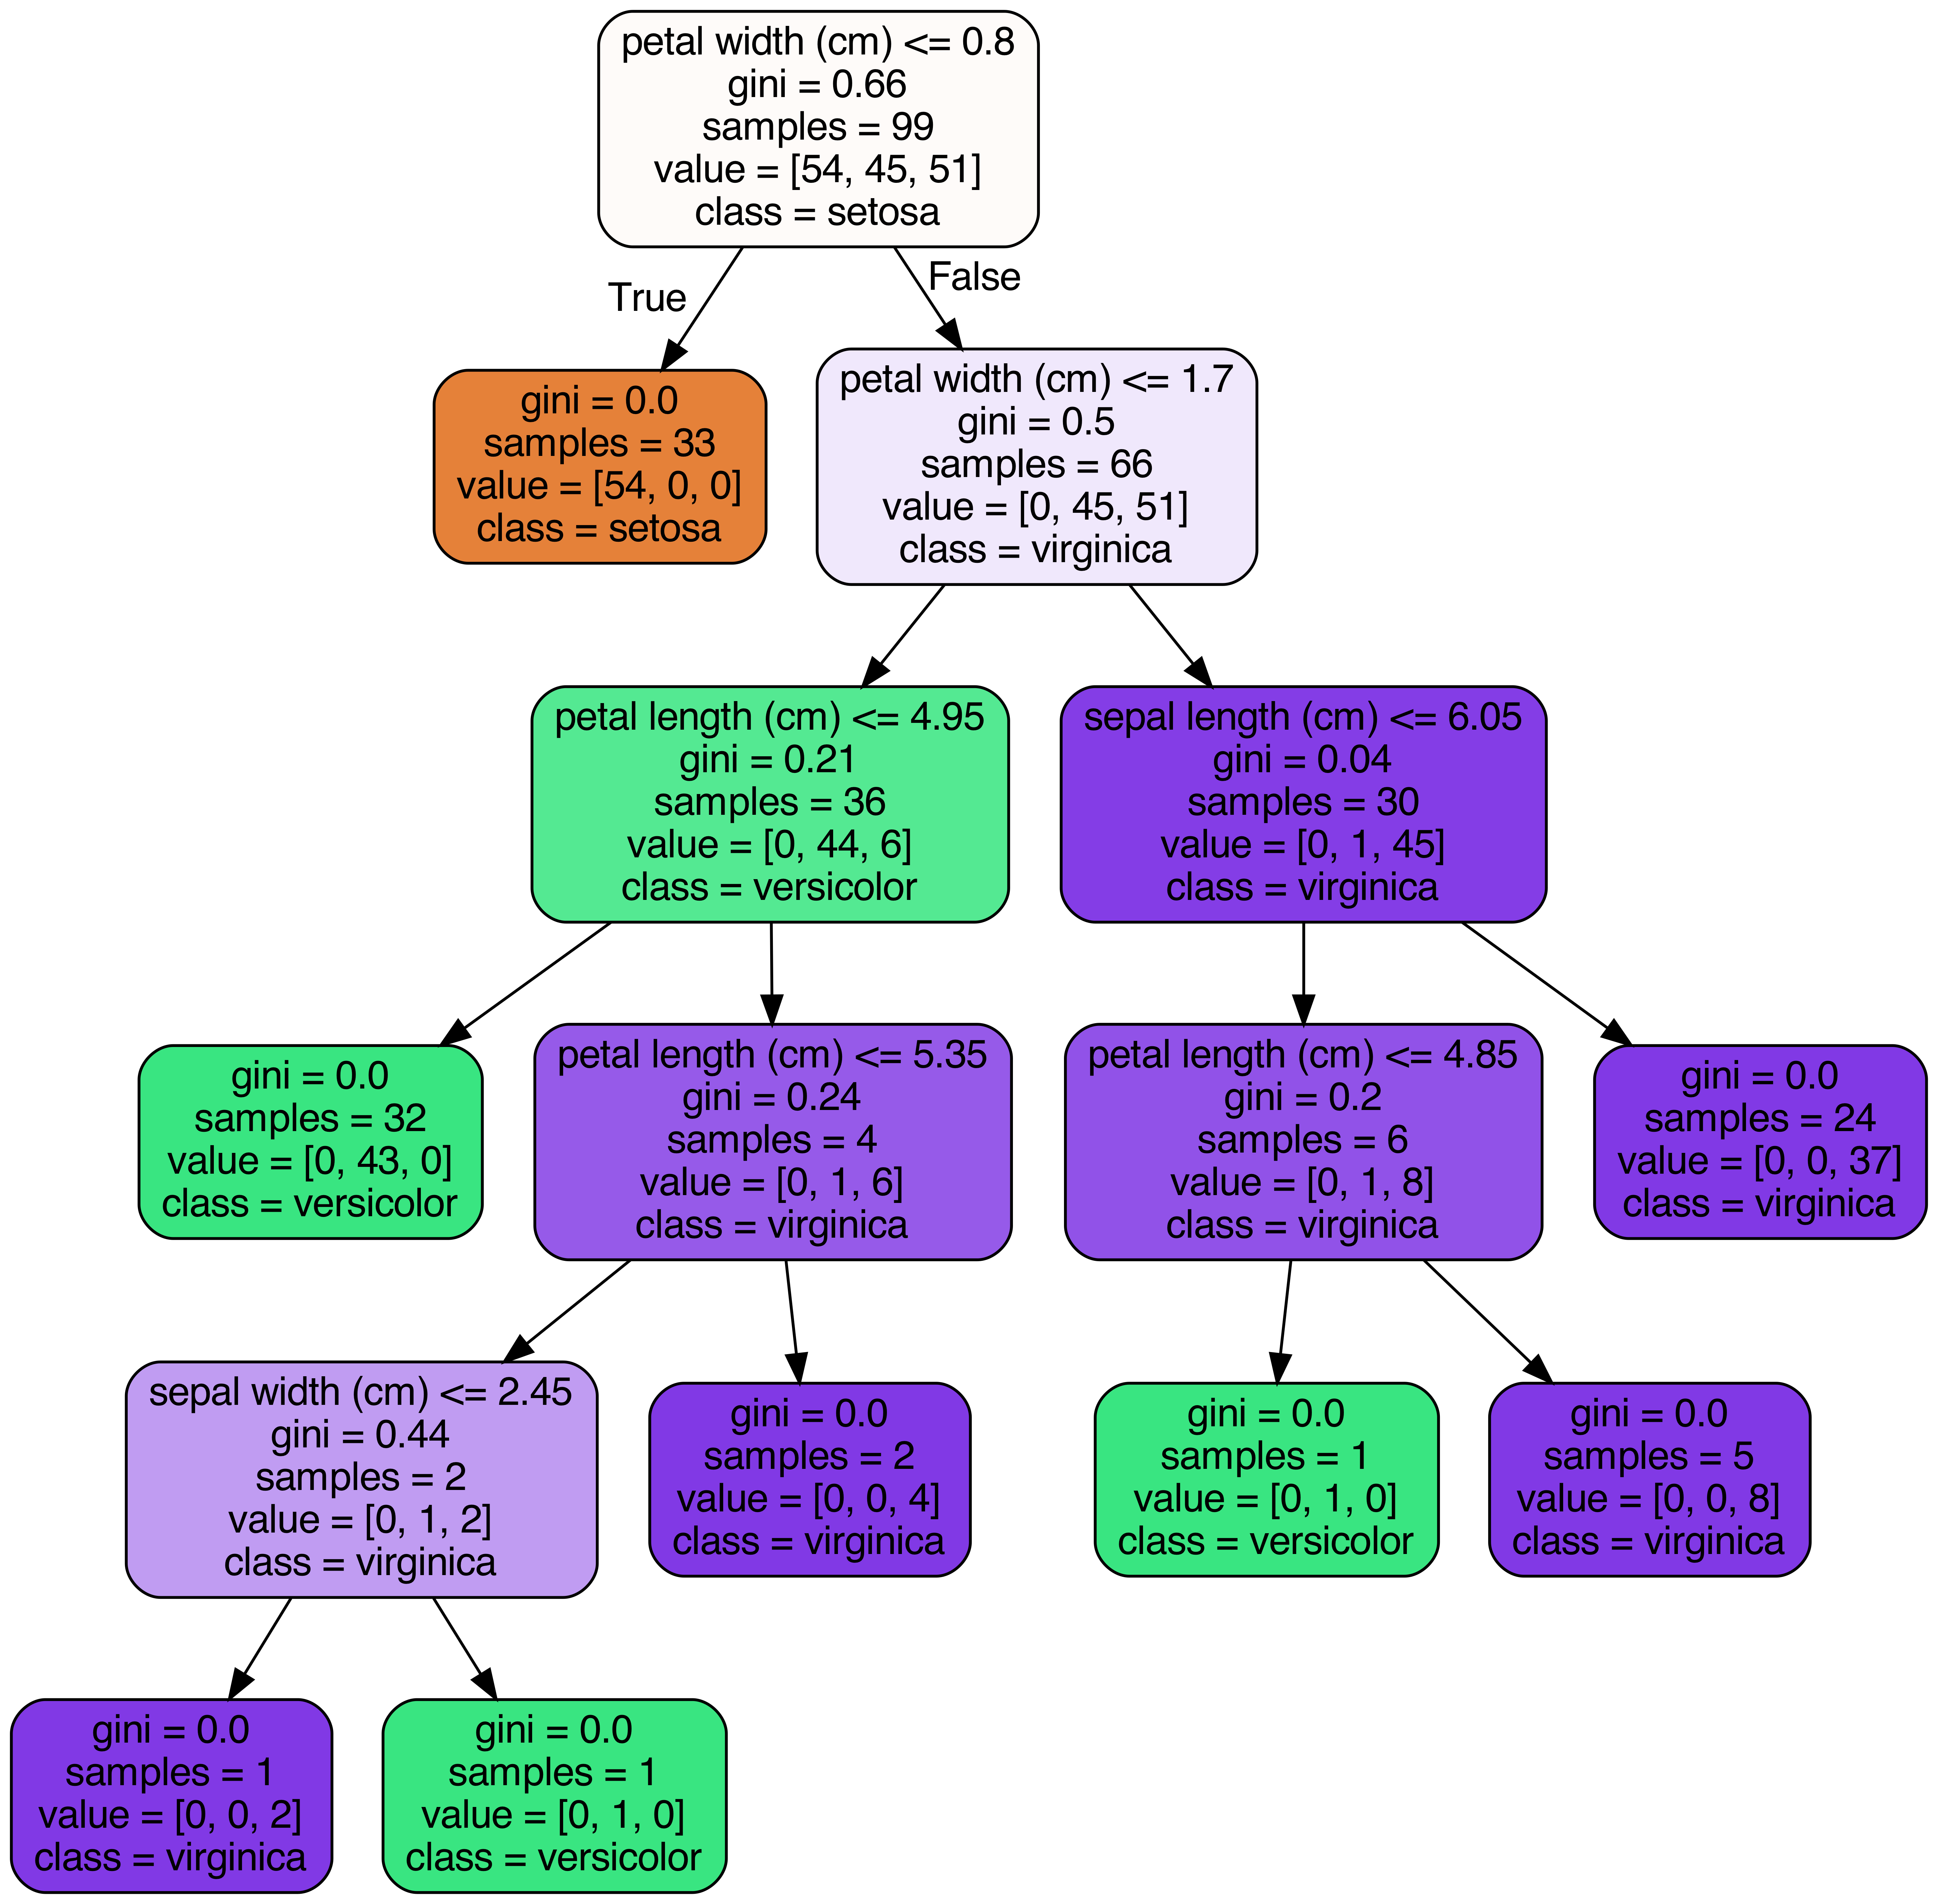

In [85]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [86]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [87]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [88]:
df.shape

(2218, 18)

In [89]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [90]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [146]:
#counts of disease 
df.disease.value_counts()

True    19
Name: disease, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [121]:
# breaking down df into two parts to perform age calculation
df_age_notna = df[df.birth_year.notnull()]
df_age_na = df[df.birth_year.isnull()]

In [122]:
df_age_notna.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [129]:
# changing birth year to int.
df_age_notna.birth_year = df_age_notna.birth_year.astype('int')

/Users/anush/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [130]:
df_age_notna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1764 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          1764 non-null   int64  
 1   global_num          1209 non-null   float64
 2   sex                 1764 non-null   object 
 3   birth_year          1764 non-null   int64  
 4   age                 1654 non-null   object 
 5   country             1764 non-null   object 
 6   province            1764 non-null   object 
 7   city                1720 non-null   object 
 8   disease             18 non-null     object 
 9   infection_case      999 non-null    object 
 10  infection_order     42 non-null     float64
 11  infected_by         419 non-null    float64
 12  contact_number      322 non-null    float64
 13  symptom_onset_date  162 non-null    object 
 14  confirmed_date      1763 non-null   object 
 15  released_date       193 non-null    object 
 16  deceas

In [132]:
# current year look up
currentYear = datetime.now().year

In [133]:
# age calculation
df_age_notna['n_age'] = currentYear - df_age_notna['birth_year']

/var/folders/n2/3jm0yqh50tqgthxmrbtwhjh40000gn/T/ipykernel_67726/219097309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_notna['n_age'] = currentYear - df_age_notna['birth_year']


In [134]:
df_age_notna.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,58
1,1000000002,5.0,male,1987,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,35
2,1000000003,6.0,male,1964,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,58
3,1000000004,7.0,male,1991,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,31
4,1000000005,9.0,female,1992,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,30


In [135]:
# imputing nan values for missing ages based on missing birth year
df_age_na['n_age'] = np.nan

/var/folders/n2/3jm0yqh50tqgthxmrbtwhjh40000gn/T/ipykernel_67726/4204937373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_na['n_age'] = np.nan


In [136]:
df_age_na.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
446,1300000001,16.0,female,NaN,40s,Korea,Gwangju,NaN,NaN,NaN,NaN,NaN,450.0,2020-01-27,2020-02-04,2020-02-20,NaN,released,NaN
447,1300000002,18.0,female,NaN,20s,Korea,Gwangju,NaN,NaN,contact with patient,NaN,1.300000e+09,8.0,NaN,2020-02-05,2020-02-20,NaN,released,NaN
448,1300000003,126.0,male,NaN,30s,Korea,Gwangju,NaN,NaN,etc,NaN,NaN,65.0,NaN,2020-02-20,NaN,NaN,isolated,NaN
449,1300000004,164.0,male,NaN,30s,Korea,Gwangju,NaN,NaN,contact with patient,NaN,1.300000e+09,30.0,NaN,2020-02-21,2020-03-18,NaN,released,NaN
450,1300000005,210.0,male,NaN,30s,Korea,Gwangju,NaN,NaN,etc,NaN,NaN,156.0,NaN,2020-02-21,2020-03-16,NaN,released,NaN


In [137]:
# rejoining the separated data frames
df_updated = pd.concat([df_age_notna, df_age_na])

In [138]:
df_updated.shape

(2218, 19)

In [140]:
df_updated.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,58.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,35.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,58.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,31.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,30.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [148]:
df_updated.isnull().sum().sort_values()

patient_id               0
global_num               0
birth_year               0
country                  0
province                 0
disease                  0
infection_order          0
infected_by              0
contact_number           0
city                    65
state                   88
confirmed_date         141
sex                    145
age                    261
n_age                  454
infection_case        1055
released_date         1995
symptom_onset_date    2025
deceased_date         2186
dtype: int64

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [142]:
df_updated.disease.fillna(value=0, inplace=True)

In [144]:
df_updated.disease.replace(to_replace='True', value=1, inplace=True)

In [145]:
df_updated.disease.value_counts()

0       2199
True      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [147]:
df_updated['global_num'].fillna(df_updated['global_num'].mean(), inplace=True)
df_updated['birth_year'].fillna(df_updated['birth_year'].mean(), inplace=True)
df_updated['infection_order'].fillna(df_updated['infection_order'].mean(), inplace=True)
df_updated['infected_by'].fillna(df_updated['infected_by'].mean(), inplace=True)
df_updated['contact_number'].fillna(df_updated['contact_number'].mean(), inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [149]:
# Dropping missing city and state rows
df_updated.dropna(axis=0, subset=['city', 'state'], inplace=True)

In [151]:
# Looking into the different values in the infection case 
df_updated.infection_case.value_counts()

contact with patient                446
etc                                 212
Guro-gu Call Center                 102
Shincheonji Church                   78
overseas inflow                      50
Onchun Church                        33
gym facility in Cheonan              29
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

Based on the different values for 'infection case' it would be hard to fill in the missing values with one of these. Instead we will have to label missing values as "Unknown". 

In [152]:
df_updated['infection_case'].fillna('Unknown', inplace=True)

In [154]:
# Looking into the different values in the sex
df_updated.sex.value_counts()

female    1088
male       835
Name: sex, dtype: int64

For sex, once again it would be difficult to impute based on this information. We will go ahead and drop rows missing values for sex

In [155]:
# Dropping rows missing 
df_updated.dropna(axis=0, subset=['sex'], inplace=True)

In [164]:
# Looking into the different values in the age column
df_updated.age.value_counts()

20s     490
50s     374
40s     296
30s     239
60s     219
70s     108
80s      77
10s      74
0s       29
90s      16
100s      1
Name: age, dtype: int64

Based on this, it seems like most of the people here are in their 20s. Since we are only missing 31 values here, we will go ahead impute the most common values '20s' for the missing ones. 

In [158]:
df_updated['age'].fillna('20s', inplace=True)

Finally for the n_age column we will use the age value to impute the missing values. For e.g. if the age column says 40s we will impute 45 into the n_age and if the age columns says 30s we will impute 35 etc. 

In [168]:
dict_age = {'20s' : 25, '30s' : 35, '40s': 45, '50s':55, '60s':65, '70s':75, '80s':85, '90s':95, '100s':100,
           '0s':5, '10s':15}
df_updated['n_age'] = df_updated['n_age'].fillna(df['age'].map(dict_age))

In [172]:
df_updated[df_updated.n_age.isnull()]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
896,3005000001,4664.816591,female,1974.988662,20s,Korea,Gangwon-do,Sokcho-si,0,etc,2.285714,2.600789e+09,5.000000,NaN,2020-02-22,2020-03-04,NaN,released,NaN
897,3005000002,4664.816591,male,1974.988662,20s,Korea,Gangwon-do,Sokcho-si,0,etc,2.285714,2.600789e+09,5.000000,NaN,2020-02-22,2020-03-04,NaN,released,NaN
1695,6005000001,383.000000,male,1974.988662,20s,Korea,Gyeongsangbuk-do,Gunwi-gun,0,Shincheonji Church,2.285714,2.600789e+09,16.000000,NaN,2020-02-22,NaN,NaN,isolated,NaN
1696,6005000002,382.000000,male,1974.988662,20s,Korea,Gyeongsangbuk-do,Gunwi-gun,0,Shincheonji Church,2.285714,2.600789e+09,13.000000,NaN,2020-02-22,NaN,NaN,isolated,NaN
1697,6005000003,871.000000,female,1974.988662,20s,Korea,Gyeongsangbuk-do,Gunwi-gun,0,Shincheonji Church,2.285714,2.600789e+09,31.000000,NaN,2020-02-24,NaN,NaN,isolated,NaN
1698,6005000004,4664.816591,female,1974.988662,20s,Korea,Gyeongsangbuk-do,Gunwi-gun,0,Shincheonji Church,2.285714,2.600789e+09,24.128954,NaN,2020-02-26,NaN,NaN,isolated,NaN
1699,6005000005,4664.816591,male,1974.988662,20s,Korea,Gyeongsangbuk-do,Gunwi-gun,0,Unknown,2.285714,2.600789e+09,24.128954,NaN,2020-02-28,NaN,NaN,isolated,NaN
1700,6005000006,4664.816591,female,1974.988662,20s,Korea,Gyeongsangbuk-do,Gunwi-gun,0,Unknown,2.285714,2.600789e+09,24.128954,NaN,2020-03-03,NaN,NaN,isolated,NaN


8 rows didn't get imputed with the mapping for some reason. We will go ahead and drop those. 

In [173]:
df_updated.dropna(axis=0, subset=['n_age'], inplace=True)

 **<font color='teal'> Check for any remaining null values.</font>**

In [174]:
df_updated.isnull().sum().sort_values()

patient_id               0
contact_number           0
infected_by              0
infection_order          0
state                    0
disease                  0
city                     0
infection_case           0
country                  0
age                      0
birth_year               0
sex                      0
global_num               0
province                 0
n_age                    0
confirmed_date           1
released_date         1708
symptom_onset_date    1731
deceased_date         1902
dtype: int64

All null values are now accounted for. 

In [175]:
df_updated.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,58.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,35.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,58.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,31.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,30.0


Remove date columns from the data.


In [176]:
df_updated = df_updated.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [177]:
print(df_updated.nunique())

patient_id         1915
global_num         1162
sex                   2
birth_year           97
age                  11
country               4
province             16
city                126
disease               2
infection_case       17
infection_order       7
infected_by         190
contact_number       65
state                 3
n_age                96
dtype: int64


Review the percent of unique values by column.

In [178]:
print(df_updated.nunique()/df_updated.shape[0])

patient_id         1.000000
global_num         0.606789
sex                0.001044
birth_year         0.050653
age                0.005744
country            0.002089
province           0.008355
city               0.065796
disease            0.001044
infection_case     0.008877
infection_order    0.003655
infected_by        0.099217
contact_number     0.033943
state              0.001567
n_age              0.050131
dtype: float64


Review the range of values per column.

In [179]:
df_updated.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,1915.0,4.038429e+09,2.194934e+09,1.000000e+09,1.600000e+09,6.001000e+09,6.001001e+09,7.000000e+09
global_num,1915.0,4.608266e+03,2.151743e+03,1.000000e+00,4.042000e+03,4.664817e+03,5.844000e+03,8.717000e+03
birth_year,1915.0,1.975323e+03,1.787449e+01,1.916000e+03,1.964000e+03,1.974989e+03,1.990500e+03,2.020000e+03
infection_order,1915.0,2.285714e+00,1.836747e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,1915.0,2.635341e+09,7.552778e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,1915.0,2.298208e+01,2.963796e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.091000e+03
n_age,1915.0,4.635927e+01,1.934160e+01,2.000000e+00,2.900000e+01,4.600000e+01,5.900000e+01,1.060000e+02


### Check for duplicated rows

In [182]:
duplicateRowsDF = df_updated[df_updated.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [187]:
dfo = df_updated.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending=False)

,VarName,LevelsCount
4,city,126
6,infection_case,17
3,province,16
1,age,11
2,country,4
7,state,3
0,sex,2
5,disease,2


In [186]:
dfo.shape

(1915, 8)

In [191]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1915 entries, 0 to 2128
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       1915 non-null   int64  
 1   global_num       1915 non-null   float64
 2   sex              1915 non-null   object 
 3   birth_year       1915 non-null   float64
 4   age              1915 non-null   object 
 5   country          1915 non-null   object 
 6   province         1915 non-null   object 
 7   city             1915 non-null   object 
 8   disease          1915 non-null   object 
 9   infection_case   1915 non-null   object 
 10  infection_order  1915 non-null   float64
 11  infected_by      1915 non-null   float64
 12  contact_number   1915 non-null   float64
 13  state            1915 non-null   object 
 14  n_age            1915 non-null   float64
dtypes: float64(6), int64(1), object(8)
memory usage: 239.4+ KB


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [192]:
dfo_num = df_updated.select_dtypes(include=['float'], exclude=['datetime'])

In [196]:
dfo_num.head()

,global_num,birth_year,infection_order,infected_by,contact_number,n_age
0,2.0,1964.0,1.0,2.600789e+09,75.0,58.0
1,5.0,1987.0,1.0,2.600789e+09,31.0,35.0
2,6.0,1964.0,2.0,2.002000e+09,17.0,58.0
3,7.0,1991.0,1.0,2.600789e+09,9.0,31.0
4,9.0,1992.0,2.0,1.000000e+09,2.0,30.0


**<font color='teal'> Plot the boxplots to check for outliers. </font>**

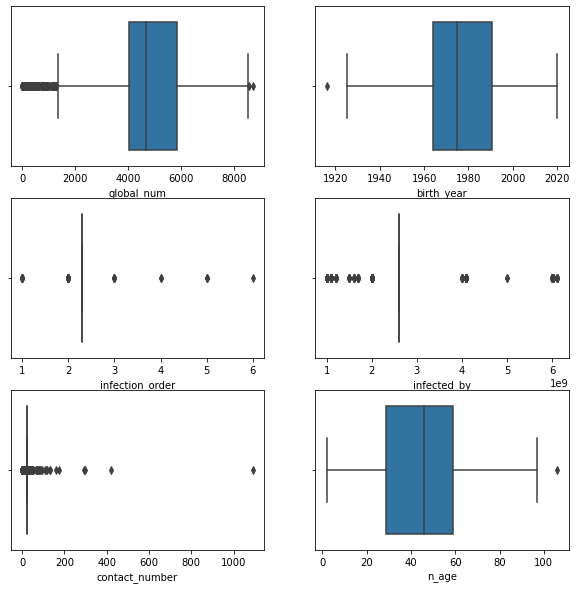

In [204]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))


sns.boxplot(x = 'global_num', data=dfo_num, ax=axes[0,0])
sns.boxplot(x = 'birth_year', data=dfo_num, ax=axes[0,1])
sns.boxplot(x = 'infection_order', data=dfo_num, ax=axes[1,0])
sns.boxplot(x = 'infected_by', data=dfo_num, ax=axes[1,1])
sns.boxplot(x = 'contact_number', data=dfo_num, ax=axes[2,0])
sns.boxplot(x = 'n_age', data=dfo_num, ax=axes[2,1]);

**<font color='teal'> Create dummy features for object type features. </font>**

In [213]:
X = df_updated

In [214]:
X = X.drop('state', axis=1)

In [215]:
X = pd.get_dummies(X)

In [216]:
X.head()

,patient_id,global_num,birth_year,infection_order,infected_by,contact_number,n_age,sex_female,sex_male,age_0s,...,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_Unknown,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,2.0,1964.0,1.0,2.600789e+09,75.0,58.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1000000002,5.0,1987.0,1.0,2.600789e+09,31.0,35.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1000000003,6.0,1964.0,2.0,2.002000e+09,17.0,58.0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1000000004,7.0,1991.0,1.0,2.600789e+09,9.0,31.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1000000005,9.0,1992.0,2.0,1.000000e+09,2.0,30.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [217]:
y = df_updated['state']

In [218]:
X.shape

(1915, 185)

In [219]:
y.shape

(1915,)

### Split the data into test and train subsamples

In [220]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [221]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [222]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [223]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.856
Random Forest: f1-score=0.823


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [224]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  2   1   0]
 [  0 314   6]
 [  0  48  12]]
Normalized confusion matrix
[[0.67 0.33 0.  ]
 [0.   0.98 0.02]
 [0.   0.8  0.2 ]]


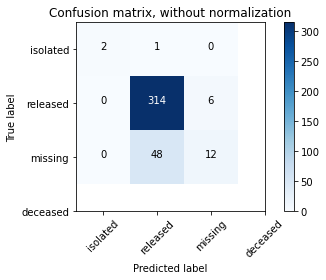

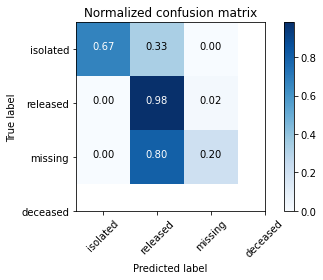

In [225]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


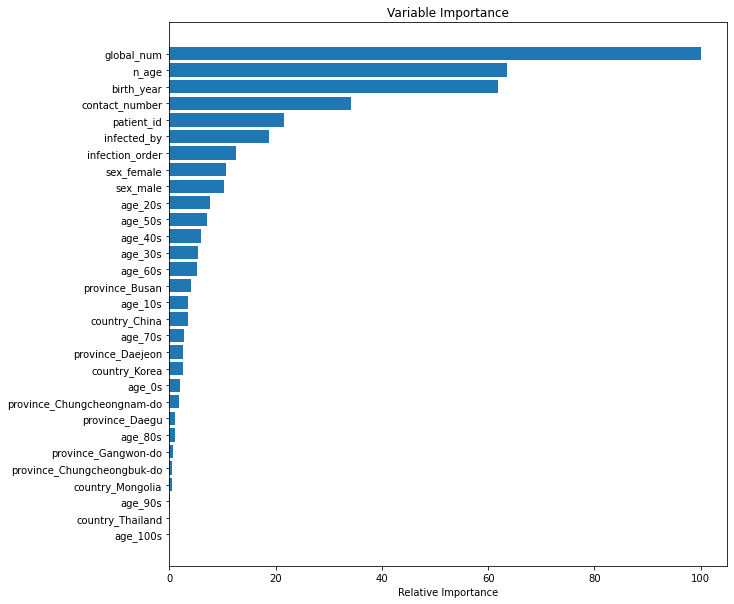

In [226]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.